# Population method - 2nd part

In [1]:
from functools import partial

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import disordered_sys.anderson
import disordered_sys.methods
import disordered_sys.display

In [2]:
%matplotlib notebook

# make experiments reproducible
rng = np.random.default_rng(seed=42)

# Spectrum from population method

In [3]:
n_p = 1000
c = 3
epsilon = 1e-3
w = .3
eigenval = 0

### Make random initial distribution of precisions $\omega$

<IPython.core.display.Javascript object>


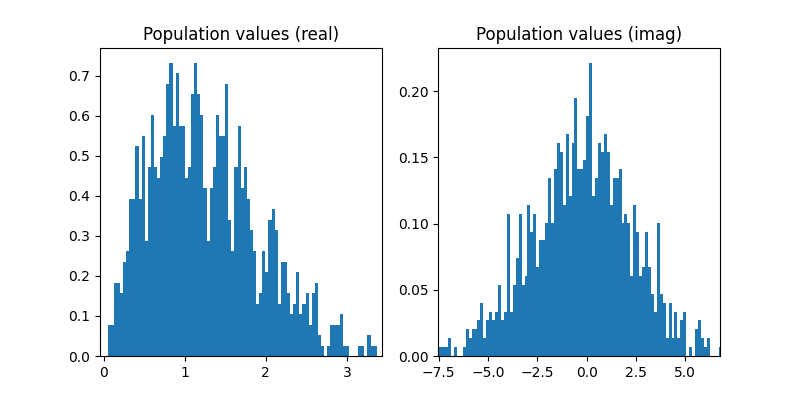

In [4]:
def make_initial_cavity_pop():
    random_realpart = rng.rayleigh(scale=1, size=n_p)
    random_imagpart = rng.normal(loc=0, scale=2.5, size=n_p)
    return random_realpart + 1j * random_imagpart

pop = make_initial_cavity_pop()

# show initial distribution
def show_complex_hist(vals, axs=None):
    if axs is None:
        _, axs = plt.subplots(ncols=2, figsize=(8, 4))
        axs[0].set_title("Population values (real)")
        axs[1].set_title("Population values (imag)")

    ax1, ax2 = axs
    ax1.set_xlim(*disordered_sys.display.plot_limits(vals.real))
    ax2.set_xlim(*disordered_sys.display.plot_limits(vals.imag))
    ax1.hist(vals.real, bins=int(n_p / 10), stacked=True, density=True)
    ax2.hist(vals.imag, bins=int(n_p / 10), stacked=True, density=True)

show_complex_hist(pop)
plt.show()

### Define cavity equation

In [5]:
def cavity_equation(l, w, epsilon, precisions):
    e = rng.uniform(low=-w, high=w)
    return 1j * (l - 1j * epsilon - e) + np.sum(1 / precisions)

### One step of the population method

In [6]:
def population_step(pop):
    population_idxs = rng.integers(low=0, high=n_p - 1, size=c)
    change_idx = rng.integers(low=0, high=n_p - 1)

    sample_values = pop.take(population_idxs[:-1])
    pop[change_idx] = cavity_equation(eigenval, w, epsilon, sample_values)

# Calculate cavity precisions

<IPython.core.display.Javascript object>


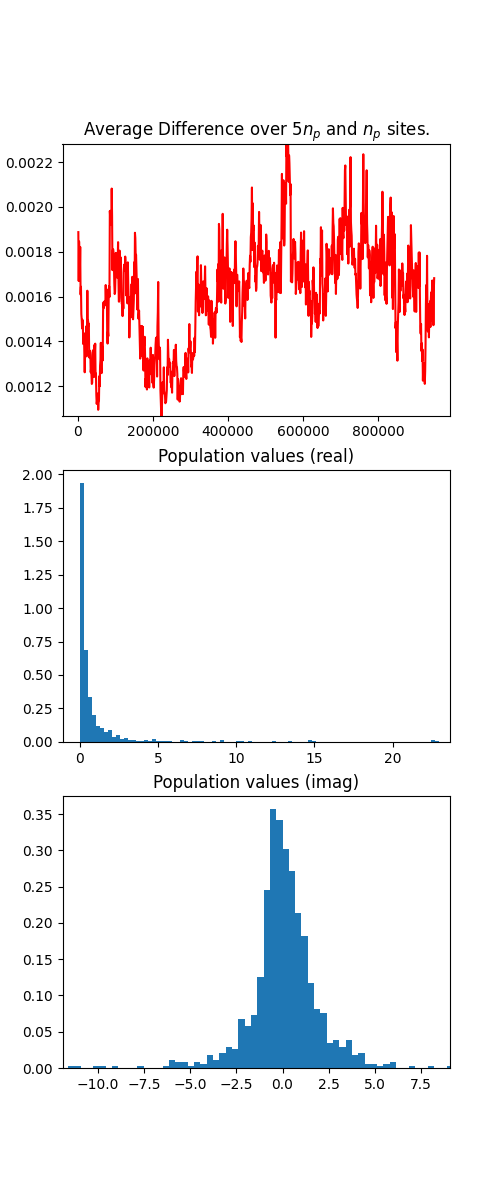

  0%|          | 0/1000000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


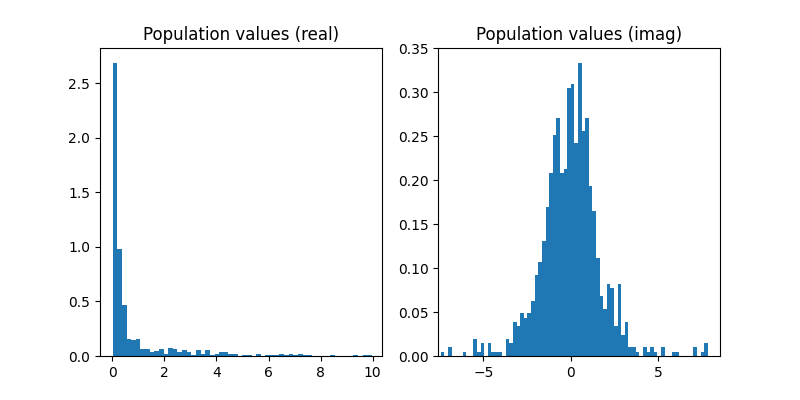

In [7]:
# initialize interactive figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(5, 12))
ax1.set_title("Average Difference over $5n_p$ and $n_p$ sites.")
update_plots = disordered_sys.display.InteractiveSimulationPlotter(
    update_every=n_p, subplots=(fig, (ax1, ax2, ax3))
)

c = 2  # !! this is important because in population step we only want to calculate the marginal cavity (!) probabilities

# run for a long time to find convergence time
max_steps = 1_000_000
disordered_sys.methods.forward_step_runner(
    pop, population_step, max_steps, pbar=tqdm, callback=update_plots
)
plt.show()

# show final distribution
show_complex_hist(pop)
plt.show()

In [8]:
# load an alternative initial population closer to equilibrium
pop = np.load("../data/initial_ev0.npz")["eigv0"]

<IPython.core.display.Javascript object>


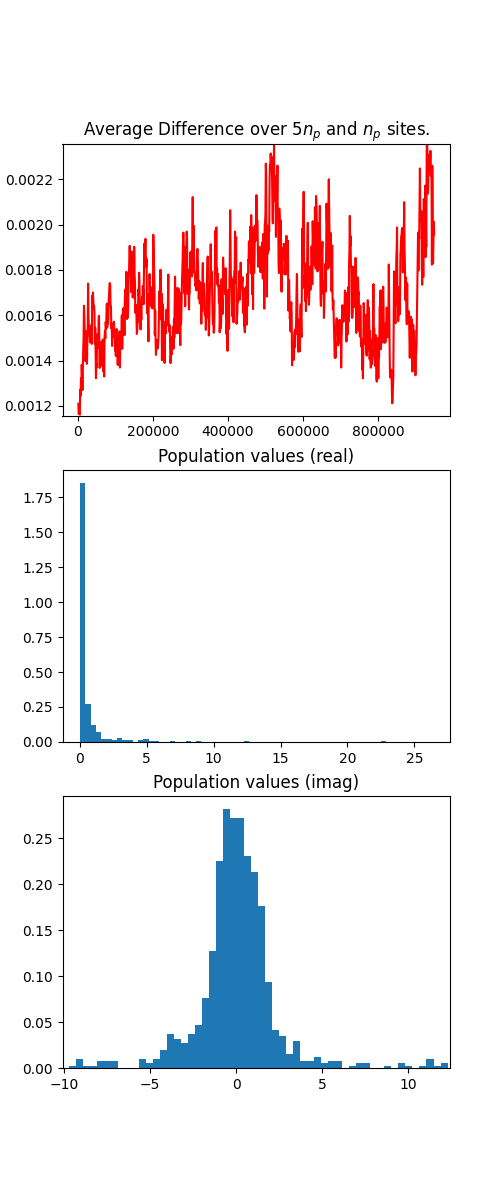

  0%|          | 0/1000000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


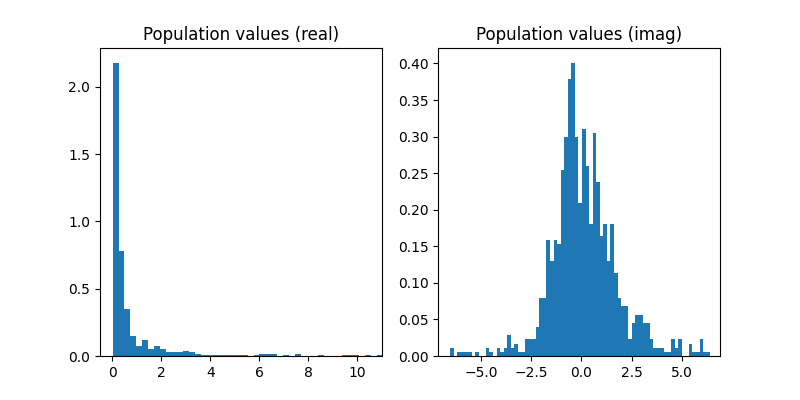

In [9]:
# initialize interactive figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(5, 12))
ax1.set_title("Average Difference over $5n_p$ and $n_p$ sites.")
update_plots = disordered_sys.display.InteractiveSimulationPlotter(
    update_every=n_p, subplots=(fig, (ax1, ax2, ax3))
)

c = 2  # !! this is important because in population step we only want to calculate the marginal cavity (!) probabilities

# run for a long time to find convergence time
max_steps = 1_000_000
pop_ens = disordered_sys.methods.forward_step_runner(
    pop, population_step, max_steps, pbar=tqdm, callback=update_plots
)
plt.show()

# show final distribution
show_complex_hist(pop)
plt.show()

# Calculate marginals using population method

<IPython.core.display.Javascript object>


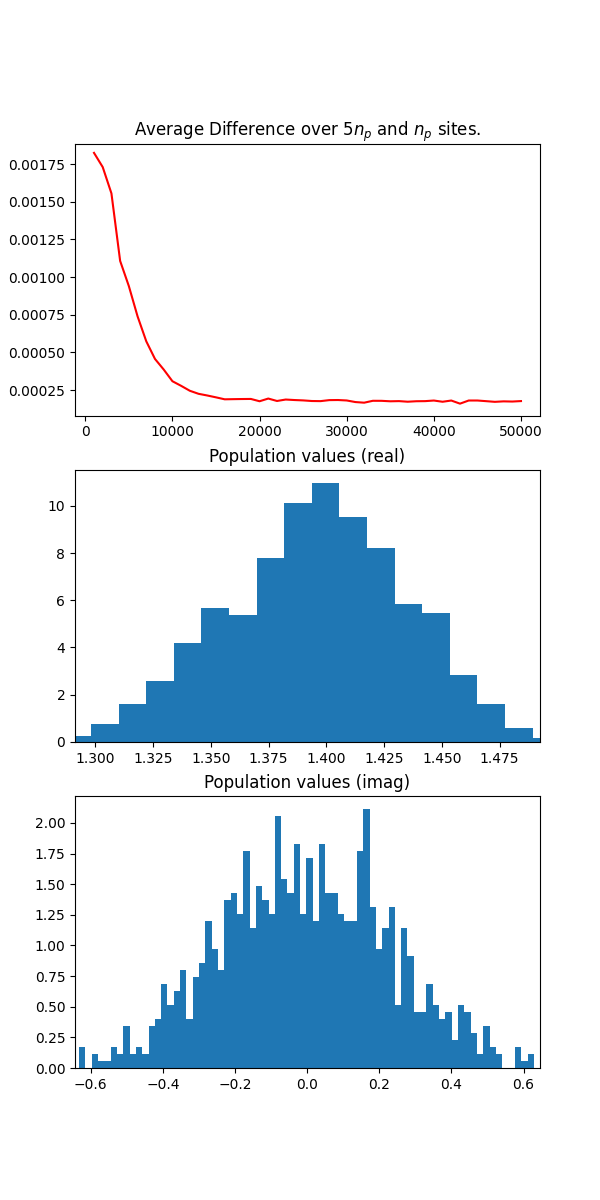

  0%|          | 0/100000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


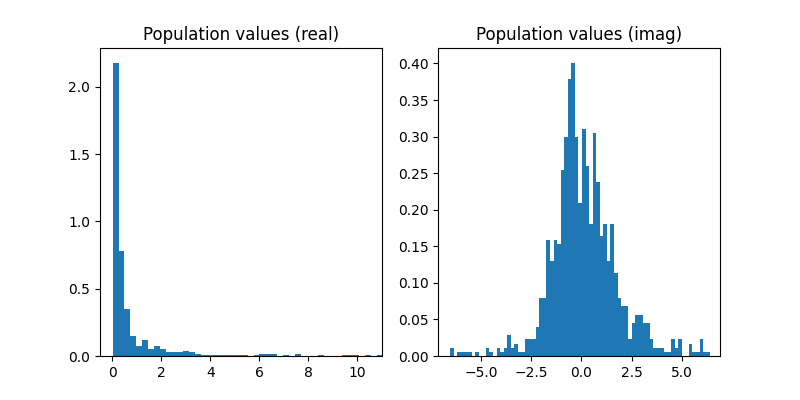

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))
ax1.set_title("Average Difference over $5n_p$ and $n_p$ sites.")
update_plots = disordered_sys.display.InteractiveSimulationPlotter(
    update_every=n_p, subplots=(fig, (ax1, ax2, ax3))
)

# choose an equilibrium sample (from the end)
marginal_pop = pop.copy()

c = 3  # !! this is important because in population step we want to calculate the marginal probabilities

# again run for a long time to find convergence time
max_steps = 100_000
pop_ens = disordered_sys.methods.forward_step_runner(
    pop, population_step, max_steps, pbar=tqdm, callback=update_plots
)
plt.show()

show_complex_hist(marginal_pop)
plt.show()

### Calculate the spectral density for the chosen $\lambda = 0$

In [11]:
G_ii = 1j / marginal_pop
rho_lambda = np.sum(G_ii.imag) / np.pi / len(G_ii)
print(rho_lambda)

0.22517723166814926


# Calculate the spectral density of the whole spectrum

In [12]:
spectrum = np.linspace(start=-3, stop=3, num=100)
w = .3
epsilon = 1e-3
n_p = 1000
c = 3

In [13]:
marginals_lambda = []
for eigv in tqdm(spectrum):
    update_eqn = partial(
        disordered_sys.anderson.cavity_eqn,
        eigv=eigv,
        impurity_w=w,
        epsilon=epsilon,
        rng=rng
    )
    cavity_pop_stepper = partial(
        disordered_sys.methods.population_step,
        update_eqn=update_eqn,
        c=c - 1,
        rng=rng
    )
    inital_pop = disordered_sys.anderson.guess_initial_cavity_marginals(
        n_p, rng=rng
    )
    cavity_pop_ens = disordered_sys.methods.forward_step_runner(
        inital_pop, cavity_pop_stepper, max_steps=100_000
    )

    marginals_pop_stepper = partial(
        disordered_sys.methods.population_step,
        update_eqn=update_eqn,
        c=c,
        rng=rng
    )
    marginals_pop_ens = disordered_sys.methods.forward_step_runner(
        cavity_pop_ens[-1], marginals_pop_stepper, max_steps=12_000
    )

    marginals_lambda.append(marginals_pop_ens[-1])
density = disordered_sys.methods.spectral_density(marginals_lambda)

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


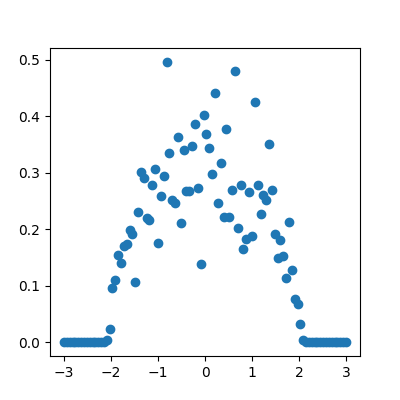

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(spectrum, np.array(density))
plt.show()